In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,4,6,9'

In [ ]:
from compass import ModelTransfuser
from compass import ScoreBasedInferenceModel as SBIm

import numpy as np
import torch
from scipy.stats import norm
import os

# Load Data

In [3]:
def load_data(data_model):
    # --- Load in training data ---
    path_training = os.getcwd() + f'/data/Chempy_model_comp_data/chempy_{data_model}.npz'
    training_data = np.load(path_training, mmap_mode='r')

    train_theta = training_data['params']
    train_x = training_data['abundances']

    # ---  Load in the validation data ---
    path_test = os.getcwd() + f'/data/Chempy_model_comp_data/chempy_{data_model}_val.npz'
    val_data = np.load(path_test, mmap_mode='r')

    val_theta = val_data['params']
    val_x = val_data['abundances']

    # --- Clean the data ---
    # Chempy sometimes returns zeros or infinite values, which need to removed
    def clean_data(x, y):
        # Remove all zeros from the training data
        index = np.where((y == 0).all(axis=1))[0]
        x = np.delete(x, index, axis=0)
        y = np.delete(y, index, axis=0)

        # Remove all infinite values from the training data
        index = np.where(np.isfinite(y).all(axis=1))[0]
        x = x[index]
        y = y[index]

        # Remove H from Elements
        y = np.delete(y, 2, 1)

        return x, y

    train_theta, train_x = clean_data(train_theta, train_x)
    val_theta, val_x     = clean_data(val_theta, val_x)

    # convert to torch tensors
    train_theta = torch.tensor(train_theta, dtype=torch.float32)
    train_x = torch.tensor(train_x, dtype=torch.float32)
    val_theta = torch.tensor(val_theta, dtype=torch.float32)
    val_x = torch.tensor(val_x, dtype=torch.float32)

    # --- add noise ---
    pc_ab = 5 # percentage error in abundance

    train_x_err = torch.ones_like(train_x)*float(pc_ab)/100.
    train_x = norm.rvs(loc=train_x,scale=train_x_err)
    train_x = torch.tensor(train_x).float()

    val_x_err = torch.ones_like(val_x)*float(pc_ab)/100.
    val_x = norm.rvs(loc=val_x,scale=val_x_err)
    val_x = torch.tensor(val_x).float()

    # --- Concatenate the data ---
    # train_data = torch.cat((train_theta, train_x), 1)
    # val_data = torch.cat((val_theta, val_x), 1)

    return train_theta, train_x, val_theta, val_x

In [4]:
theta_442, x_442, val_theta_442, val_x_442 = load_data('442')
theta_742, x_742, val_theta_742, val_x_742 = load_data('742')
theta_842, x_842, val_theta_842, val_x_842 = load_data('842')

# Initialize ModelTransfuser

In [5]:
MTf = ModelTransfuser()

# Add Data to ModelTransfuser

In [6]:
# MTf.add_data('Chempy_442', theta_442, x_442, val_theta_442, val_x_442)
# MTf.add_data('Chempy_742', theta_742, x_742, val_theta_742, val_x_742)
# MTf.add_data('Chempy_842', theta_842, x_842, val_theta_842, val_x_842)

# Initialize the SBI Models

In [7]:
# MTf.init_models(sde_type="vesde", sigma=2.5, hidden_size=36, depth=5, num_heads=1, mlp_ratio=3)

# Train the SBI Models

In [8]:
# MTf.train_models(path="data/MTf_model_comp", batch_size=512, device="cuda")

In [9]:
model_442 = SBIm.load("data/MTf_model_comp/Chempy_442_checkpoint.pt", device="cuda")
model_742 = SBIm.load("data/MTf_model_comp/Chempy_742_checkpoint.pt", device="cuda")
model_842 = SBIm.load("data/MTf_model_comp/Chempy_842_checkpoint.pt", device="cuda")

MTf.add_model('Chempy_442', model_442)
MTf.add_model('Chempy_742', model_742)
MTf.add_model('Chempy_842', model_842)

Model Chempy_442 added to transfuser.
Model Chempy_742 added to transfuser.
Model Chempy_842 added to transfuser.


# Compare the Models on Observations

In [13]:
observations = val_x_842[:100]
err = val_x_842[:100].abs() * 0.05

In [15]:
MTf.compare(x=observations, err=err, timesteps=100, final_corrector_steps=5, device="cuda")

Probabilities of the models after 100 observations:
Chempy_442:   0.00 %
Chempy_742:   0.00 %
Chempy_842: 100.00 %

Model Chempy_842 fits the data best with a relative support of 100.0% among the considered models and could reject the null hypothesis decisively.


# Plot Results

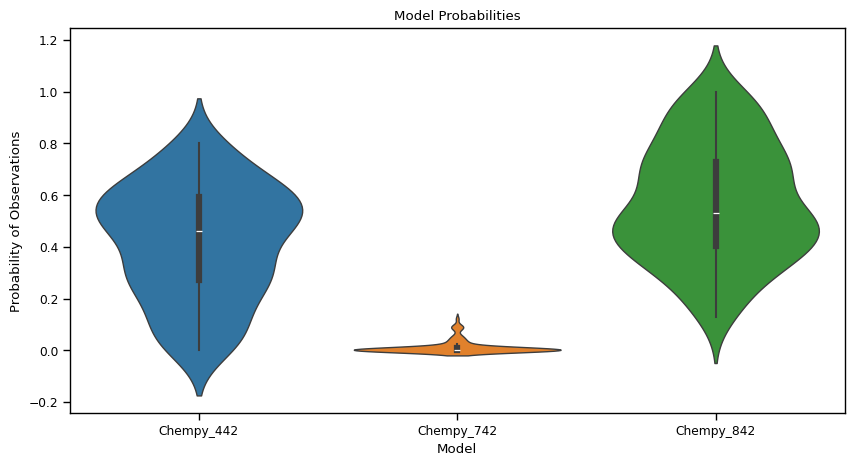

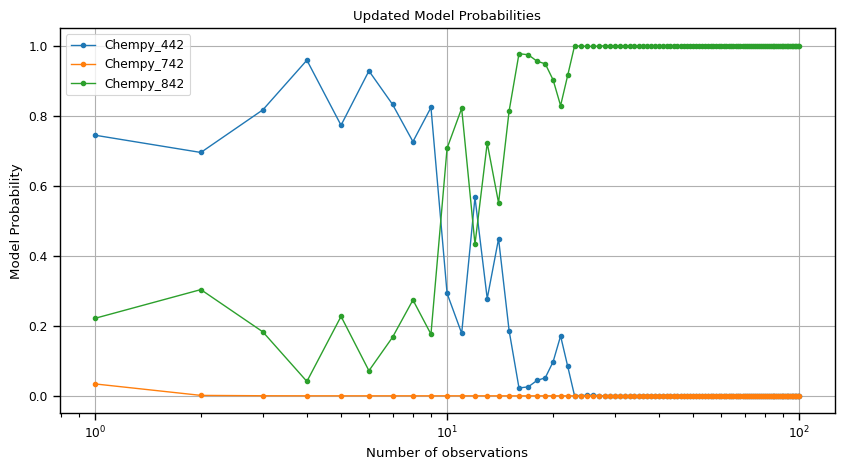

In [16]:
MTf.plots(path="data/MTf_model_comp")